# Hypotheses

This notebook contains some one-off tests for hypotheses

- Flood releases from Falcon cause peaks in salinity
- Precipitation events cause peaks in salinity
- Why is the salinity at Los Ebanos so variable?

TODO
- Maybe try dropping null weeks for the rainfall analysis.
- Don't get too hung up on the details, but try again with the custom regression function for rainfall and salt load, then get started on the report: see the email for details

### Notes

- This was an extra [rainy year](https://www.weather.gov/media/bro/wxevents/2021/pdf/RGV2021SummerSummary.pdf)
- Anzalduas Dam had large outflows that I'm guessing corresponded with the [planting season](https://hidalgo.agrilife.org/files/2020/09/Vegetable-Planting-Guide-for-Rio-Grande-Valley.pdf)
- There is a loss of water during high flows, but during mid May there is a reversal of this (gain of water right before a drop in flows). Does this mean that the flow time is off?
- Salt load is stationary (no seasonality), and autocorrelates heavily with a day or two lag
- Most of the data is not normally distributed (Pearson correlation is inappropriate)
- There are steady gains from Puertecitos that seem to correlate with the diff in the flow_in vs flow_out


In [1]:
# Meta functions
# Change me to `%matplotlib qt` for interactive mode
%matplotlib inline  
%load_ext autoreload
%autoreload 2

In [52]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gumbel_r, chi2, exponpow, spearmanr
from sklearn.metrics import mutual_info_score

from src.lib import utils
from src.lib import stats
from src.lib import plot
from src.lib import analysis
from src.lib import constants

In [3]:
# Global variables
pd.set_option('display.max_rows', 1000)

# Set the target reach. Update this so examine your reach specifically
REACH = 2

# This is the time frame for the study, limit all results to this
START = "01/01/2021"
END = "12/31/2023"

In [33]:
# Load the datasets
OASIS_output_file = "data/all_data_12_02.csv"
df = pd.read_csv(
    OASIS_output_file, 
    header=0,  # Read the header
    skipinitialspace=True,  # OASIS outputs have leading spaces
    names=constants.FIELD_NAMES,  # Map the ideal field names to the csv, order matters so make sure the 1v file is 1-1 with the list
    parse_dates=[constants.TIMESTAMP_KEY],  # Process the date string as a datetime
    index_col=constants.TIMESTAMP_KEY  # Set the date as the index for the dataframe
)

# Take the moving average over a 5 day window to smooth out variances introduced by the time to travel value (1 day per reach)
df_5_ma = df.rolling(window=7).mean()

# Get the HUC data as well
df_huc = utils.huc2df(
    files=[f"data/Rain_Ave_Date_{REACH}N.csv", f"data/Rain_Ave_Date_{REACH}S.csv"],
    start=START,
    end=END,
)

## Flood Releases

- Track the precentage flow from Falcon downstream * (upstream + in - out) / upstream so that we can tell how much of the flow is from falcon

In [34]:
other = {
    1: df["RioAlamo"] - df["MAleman"] - df["CdMier"] - df["CdCamargo"] - df["DrenRancherias"] - df["DrenFresnos"] + df["RioSanJuan"],
    2: -1 * df["DrenIndiosPuertecitos"] - df["DrenHuizaches"] - df["GDOrdaz"],
    3: -1 * df["DrenMorillo"] - df["AnzalduasCanal"] - df["Reynosa"],
    6: -1 * df["Matamoros"]
}

df_5_ma["FalconRatioR0"] = 1.0
for i in range(1, 7):
    df_5_ma[f"FalconRatioR{i}"] = df_5_ma[f"FalconRatioR{i - 1}"] * df_5_ma[f"UpstreamR{i}"] / (
        df_5_ma[f"UpstreamR{i}"] + (
            df_5_ma[f"DownstreamR{i}"] 
            + df_5_ma[f"MassBalanceR{i}"]
        )
    )

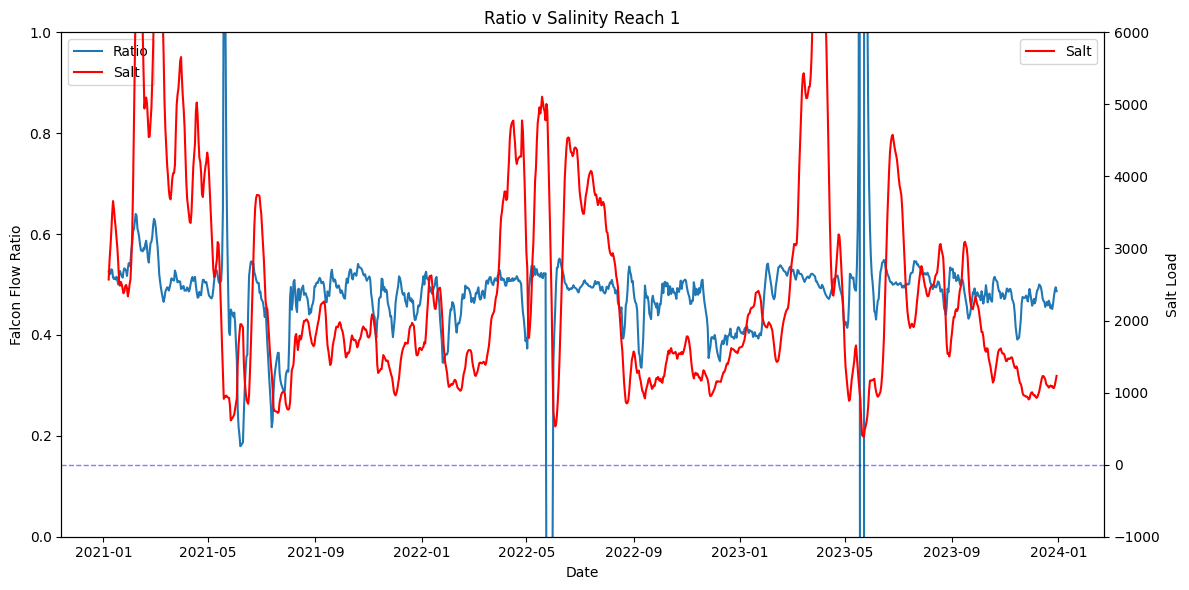

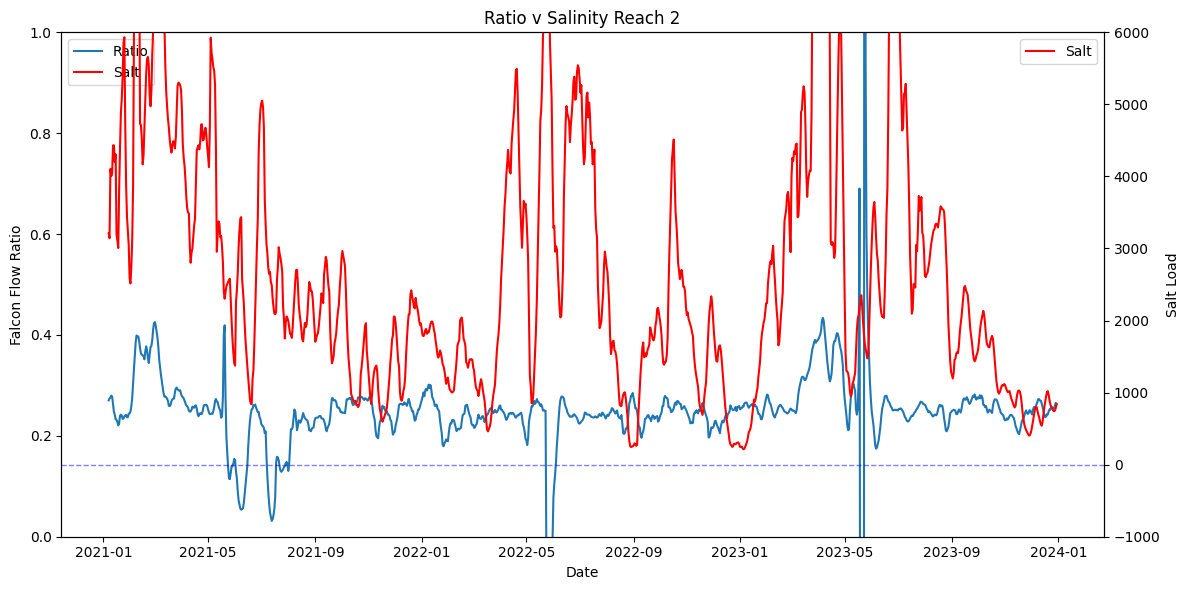

In [35]:
# Falcon Flow Ratio to Salt Load
for i in range(1, 3):
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Falcon Flow Ratio')
    ax1.set_ylim(0,1)
    
    sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'FalconRatioR{i}', data=df_5_ma, ax=ax1, label='Ratio')
    
    # Create the second y-axis
    ax2 = ax1.twinx()
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Salt Load')
    ax2.set_ylim(-1000,6000)
    
    # Plot the Salinity line on the right y-axis
    sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SaltR{i}', data=df_5_ma, ax=ax2, color='red', label='Salt')
    
    # Horizontal line
    ax2.axhline(y=0, color='blue', linestyle='--', alpha=0.5, linewidth=1)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f'Ratio v Salinity Reach {i}')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Rain Impacts

Using a modified Miguel Duran's analysis, and Miguel Pavon's data, do rain events cause spikes in salinity?

- Sample weekly maxima for rainfall, only account for weeks with rainfall
- Fit sampled data to the Gumbel distribution
- Check to see if distributions correlate

/var/folders/tb/67j_h8c519z7009dtd4hlm3c0000gp/T/ipykernel_26132/214660306.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


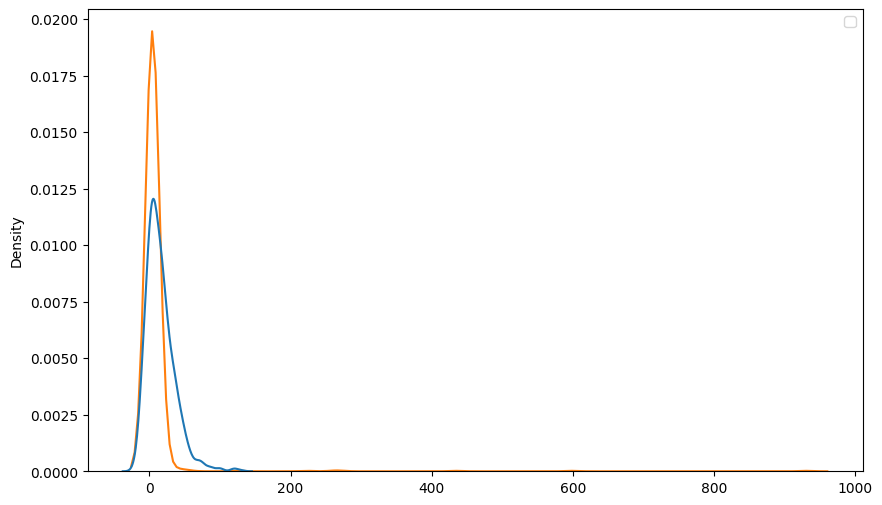


Pearson Correlation: 0.020616455386611533
Spearman Correlation: 0.023884535884535884
Mutual Information Score: 0.03935969472838245



In [48]:
# Join the HUC data on the main dataframe
df_combined = df.join(df_huc)

# Fit rainfall and salinity to the Gumbels and get back the correlations
_, _, precip = stats.gumbel_fit(df_combined, "mean_precip", sample_size=7, size=1000, drop_val=0)
deefe, scale, loc = chi2.fit(df_combined["SaltR2"].resample("7d").mean().dropna().astype(int))
salt = chi2.rvs(df=deefe, loc=loc, scale=scale, size=1000)
corrp = np.corrcoef(precip, salt)[0, 1]
corrs = np.corrcoef(np.argsort(precip), np.argsort(salt))[0, 1]

def discretize_data(data, bins=50):
    return np.digitize(data, np.histogram(data, bins=bins)[1])

# Compute mutual information
mutual_info = mutual_info_score(discretize_data(precip), discretize_data(salt))

plt.figure(figsize=(10, 6))
sns.kdeplot(data=[precip, salt])
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"""
Pearson Correlation: {corrp}
Spearman Correlation: {corrs}
Mutual Information Score: {mutual_info}
""")

In [11]:
df_combined_ma = df_combined.rolling(window=7).mean()
flow_in = df_combined_ma["UpstreamR2"]
flow_out = df_combined_ma["DownstreamR2"] 
flow_local = df_combined_ma["mean_precip"]
salt_in = df_combined_ma["SaltR1"]
salt_out = df_combined_ma["SaltR2"]
x_data = np.array([flow_in, flow_out, salt_in, salt_out])
optimal_sal = analysis.regression_error(
    model_function=analysis.base_salt_mass_balance,
    x_data=x_data,
    y_data=flow_local,
    p0=[3000],
    bounds=((0,20000)),
)

Optimized parameter: 19999.999999999996
Length of y_data_valid: 755
Length of y_fit_valid: 755
Unique values in y_data_valid: 311
Unique values in y_fit_valid: 755
Mean Squared Error: 56.21945826493199
Mean Absolute Error: 4.195305012602213
Pearson Correlation: -0.2365190674189016
Spearman Correlation: nan


## Upstream

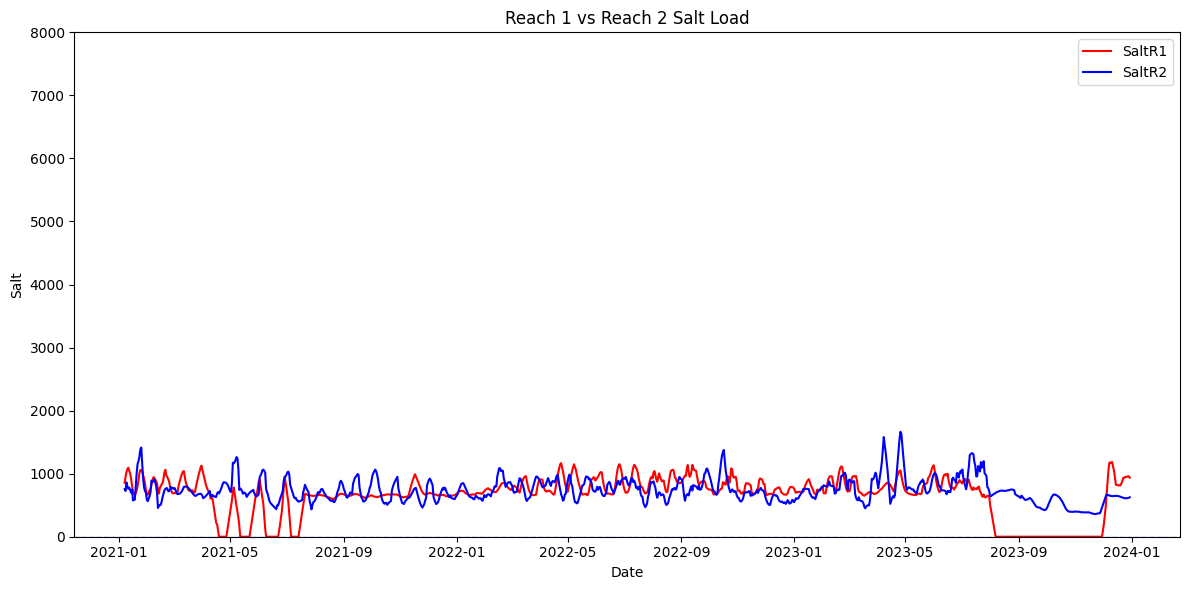

In [37]:
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Salt')
ax1.set_ylim(0,8000)

# Plot the Salinity line on the right y-axis
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SalinityRioGrandeCity', data=df_5_ma, ax=ax1, color='red', label='SaltR1')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SalinityLosEbanos', data=df_5_ma, ax=ax1, color='blue', label='SaltR2')

ax1.axhline(y=0, color='blue', linestyle='--', alpha=0.5, linewidth=1)

plt.title(f'Reach 1 vs Reach 2 Salt Load')
plt.legend()
plt.tight_layout()
plt.show()

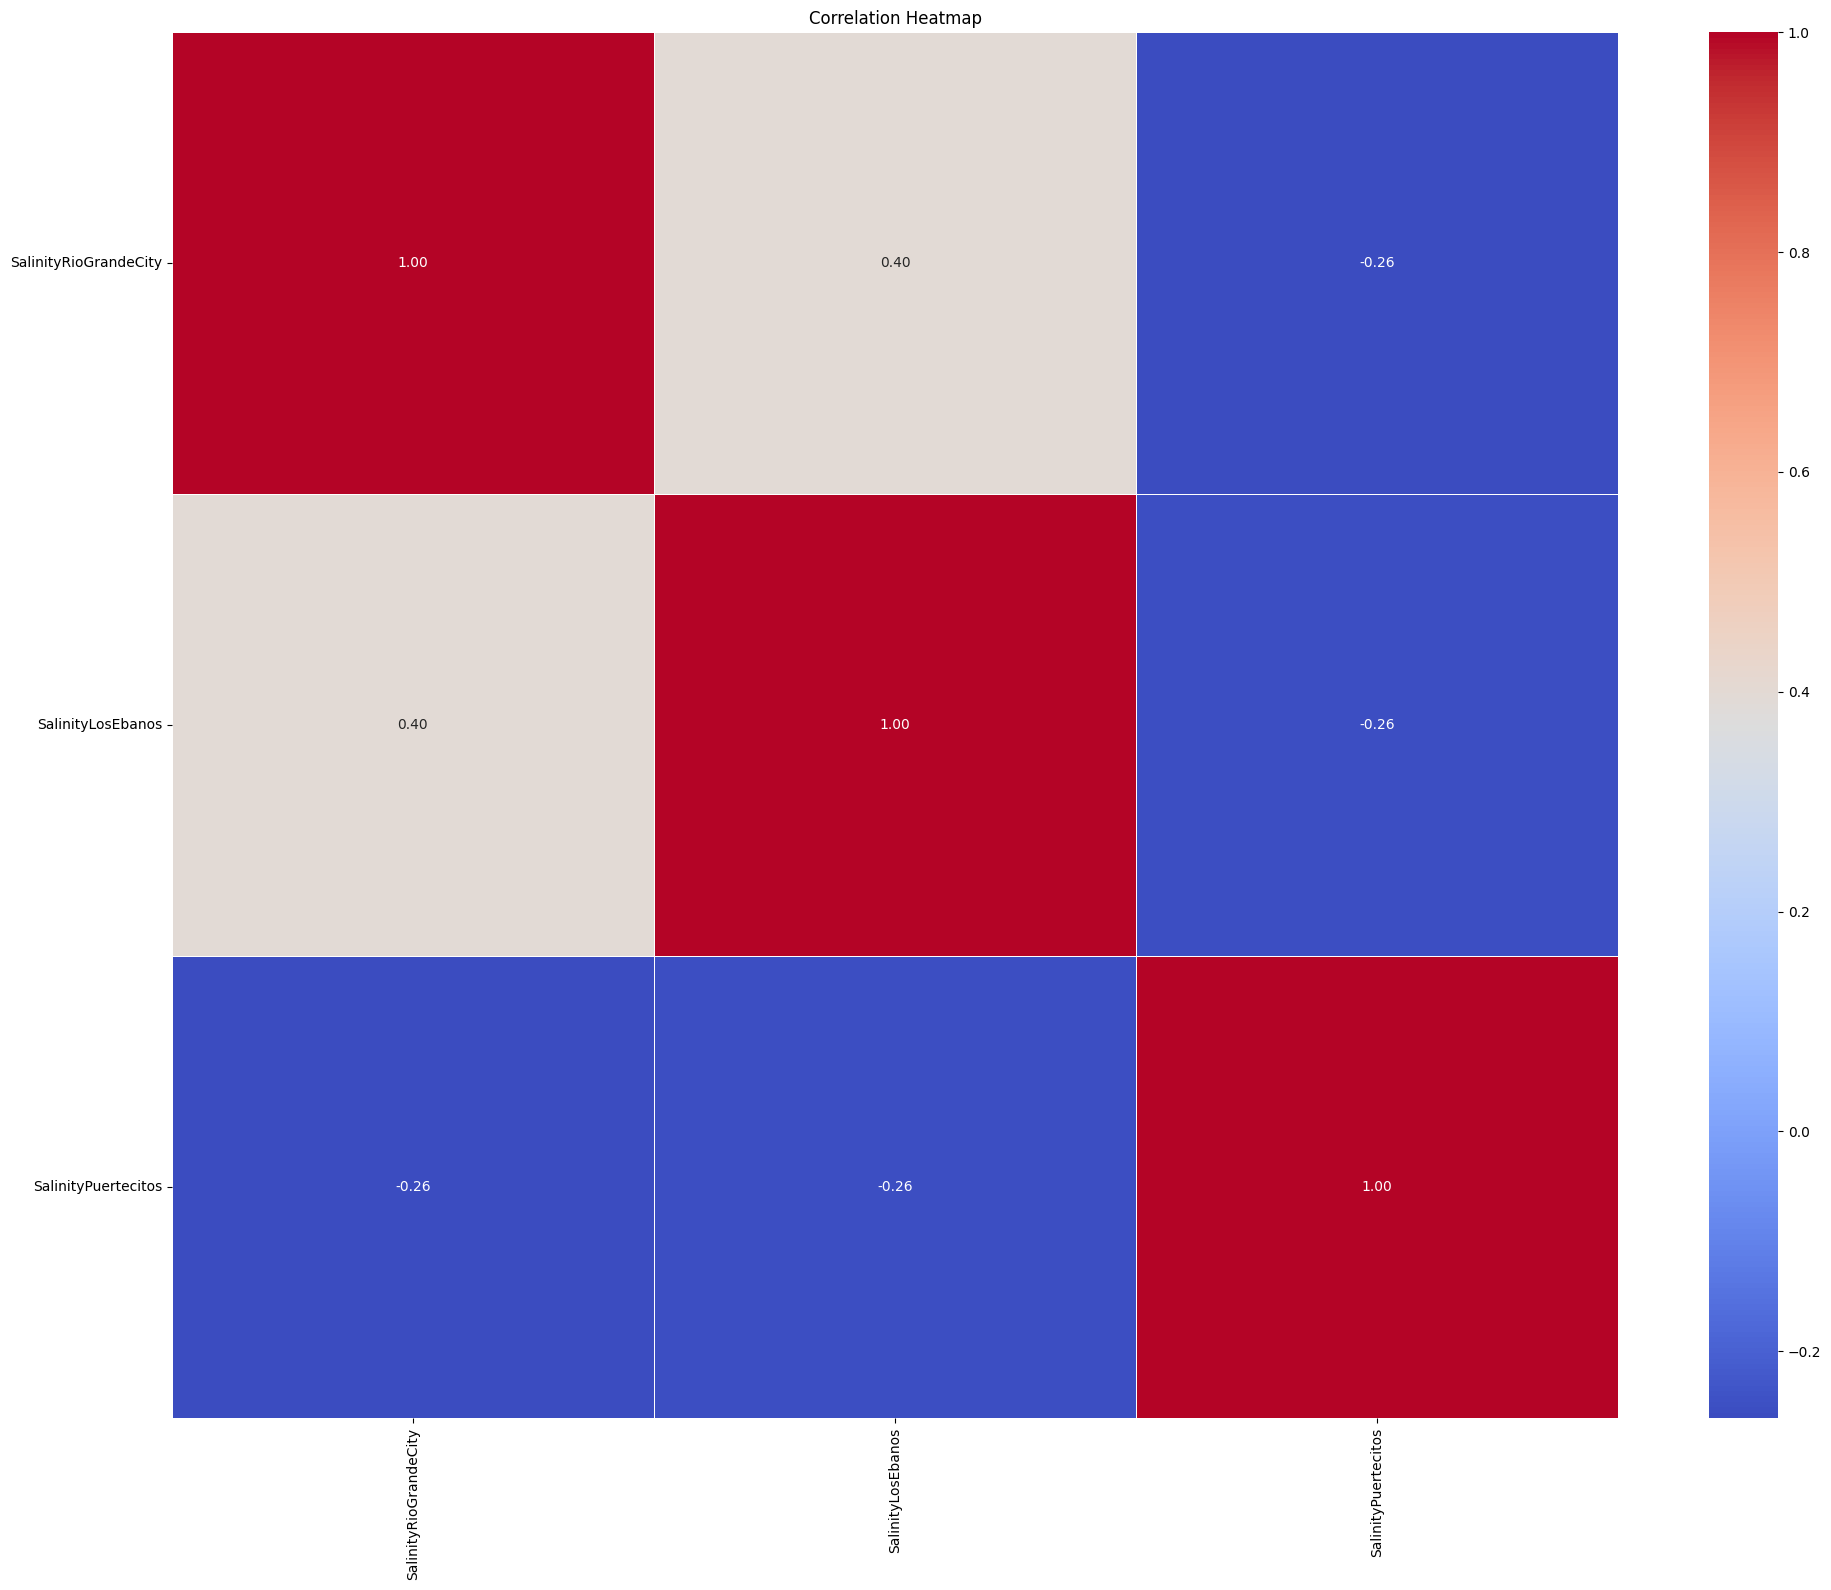

In [51]:
stats.plot_correlation_heatmap(df_5_ma[["SalinityRioGrandeCity", "SalinityLosEbanos", "SalinityPuertecitos"]])